In [1]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os
import time

In [2]:
dim = 2

In [3]:
192*2

384

In [4]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"),
                                         elementRes=(560,320), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(28e5,9e5)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [5]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [6]:
#Boundary conditions

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
BWalls = linearMesh.specialSets["MinJ_VertexSet"]



#free sides, no slip top
mixedslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                                                  nodeIndexSets=(IWalls+BWalls, JWalls)  )

##Geometry

In [11]:
#sphereShape = uw.shapes.Sphere(0.5e5, 2, centre=(14e5,3e5))

from shapely.geometry import Point

#Shapely stuff

sphereshape = Point((14e5,3e5)).buffer(5e4)

##Particles

In [9]:
# We create swarms of particles which can advect, and which may determine 'materials'
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )

# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=36 )
# Now use it to populate.
gSwarm.populate_using_layout(layout=layout )

# Lets initialise the 'materialVariable' data to represent two different materials. 

mantleIndex = 1
lithosphereIndex = 2
airIndex = 3
sphereIndex = 4


# Set the material to heavy everywhere via the numpy array
materialVariable.data[:] = mantleIndex

In [13]:
for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    x = gSwarm.particleCoordinates.data[particleID][0]
    y = gSwarm.particleCoordinates.data[particleID][1]  
    if gSwarm.particleCoordinates.data[particleID][1] > 6e5 and gSwarm.particleCoordinates.data[particleID][1] < 7e5:
        materialVariable.data[particleID] =  lithosphereIndex
    elif gSwarm.particleCoordinates.data[particleID][1] > 7e5:
        materialVariable.data[particleID] =  airIndex
    elif Point(x,y).within(sphereshape):
        materialVariable.data[particleID] =  sphereIndex
    else:
        materialVariable.data[particleID] =  mantleIndex



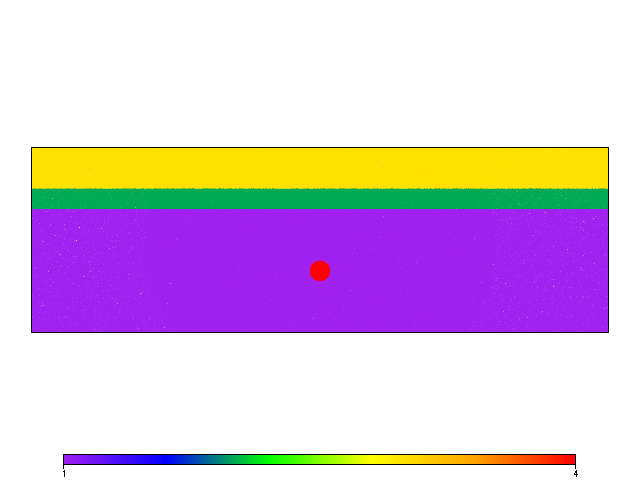

In [14]:
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
#fig1.save_database('test_pol.gldb')
fig1.show()

In [15]:
incr = 5000.
xps = np.linspace(0 + 1000.,28e5 - 1000., 10000)
#yps = [7e5 + 7e3*np.cos(2*np.pi*(i/28e5)) for i in xps]
yps = [7e5 for i in xps]

surfswarm = uw.swarm.Swarm( feMesh=elementMesh )
surfswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32)

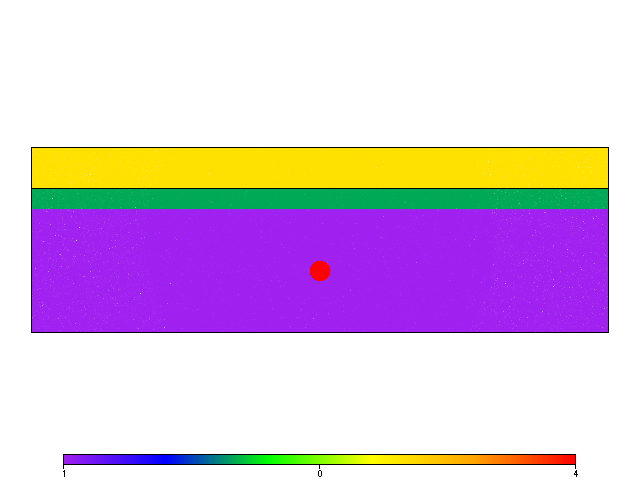

In [16]:
fig2 = plt.Figure()
fig2.Points( swarm=surfswarm, pointSize=1.0)
fig2.Points( swarm=gSwarm, colourVariable=materialVariable )
fig2.save_database('test_pol.gldb')
#fig1.save_database('test_pol.gldb')
fig2.show()

##Material properties

In [17]:
print(1e23, 10.**23)

(1e+23, 1e+23)


In [18]:
#
viscosityMapFn  = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = {mantleIndex:1e21,airIndex:1e18,lithosphereIndex:1e23, sphereIndex:1e20} )


densityMapFn = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = {mantleIndex:3300.,airIndex:0., lithosphereIndex:3300., sphereIndex:3200.} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
if dim ==2:
    gravity = ( 0.0, -10.0 )
else:
    gravity = ( 0.0, -10.0, 0.0)
    

# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading

buoyancyFn = gravity*densityMapFn

In [19]:
# Setup the Stokes system again, now with full viscosity
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[mixedslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityMapFn), 
                              bodyForceFn=buoyancyFn)

In [20]:
solver = uw.systems.Solver(stokesPIC)

In [21]:
solver.solve()

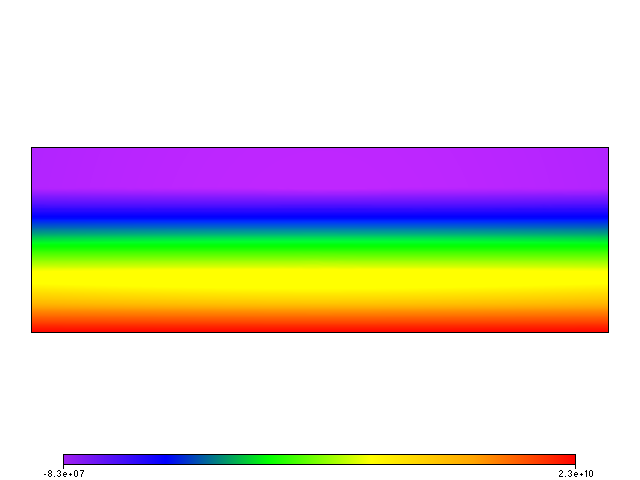

In [22]:
fig3 = plt.Figure()
fig3.Surface(pressureField, linearMesh)
fig3.show()

In [23]:
# Create advector objects to advect the swarms. We specify second order integration.
advector1 = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector( swarm=surfswarm, velocityField=velocityField, order=2)

In [24]:
# Stepping. Initialise time and timestep.
realtime = 0.
step = 0

timevals = []
vrmsvals = []

In [25]:
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

def maxtop():
    test = surfswarm.particleCoordinates.data
    return np.flipud(test[test[:,1].argsort()])[0:100,1].mean()
    

In [26]:
sectoka = (3600*24*365*1000.)
sectoka

31536000000.0

In [27]:
# create integral to get diff 
maxheight = []

start = time.clock()
while step<20:
    #stokesPIC2.solve(nonLinearIterate=True)
    solver.solve()
    dta = advector1.get_max_dt()
    dt = min(sectoka/2., dta)  #advect at no larger than 500 year intervals
    if step == 0:
        dt = 0.
    # Advect swarm using this timestep size
    advector1.integrate(dt)
    advector2.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    Rms = rms()
    MaxT = maxtop()
    maxheight.append(MaxT)
    #f_o.write((2*'%-15s ' + '\n') % (realtime,Rms))
    if step % 1 == 0:
        print 'step =',step, 'rms', Rms, 'max height', MaxT

step = 1 rms 2.25247044704e-10 max height 700000.0
step = 2 rms 2.25247044704e-10 max height 700004.123625
step = 3 rms 2.16587700209e-10 max height 700008.028142
step = 4 rms 2.11043118174e-10 max height 700011.780402
step = 5 rms 2.04167664714e-10 max height 700015.415735
step = 6 rms 1.98567552053e-10 max height 700018.882316
step = 7 rms 1.91272322673e-10 max height 700022.087979
step = 8 rms 1.86175470074e-10 max height 700025.096926
step = 9 rms 1.78524467921e-10 max height 700027.862358
step = 10 rms 1.78609612623e-10 max height 700030.629914
step = 11 rms 1.78628271887e-10 max height 700033.398306
step = 12 rms 1.78561305191e-10 max height 700036.166503
step = 13 rms 1.7891589401e-10 max height 700038.942867
step = 14 rms 1.74568989026e-10 max height 700041.565051
step = 15 rms 1.74590395445e-10 max height 700044.189913
step = 16 rms 1.70193854284e-10 max height 700046.732776
step = 17 rms 1.70193854284e-10 max height 700049.27566
step = 18 rms 1.70031145546e-10 max height 7000

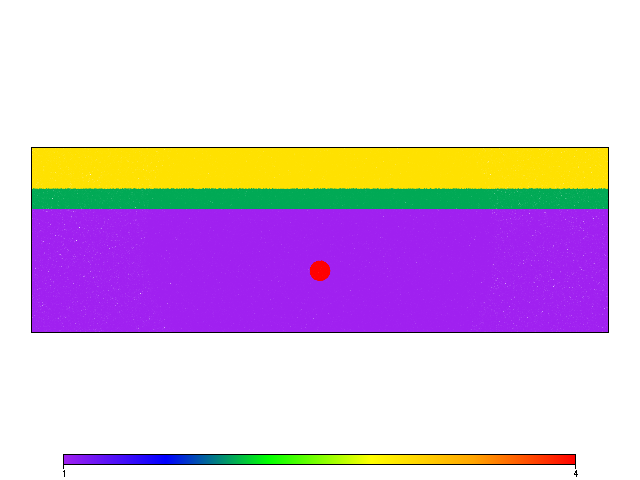

In [29]:
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
fig1.VectorArrows(velocityField, linearMesh,lengthScale=1e13)
fig1.show()

In [30]:
realtime

299592000000.0

In [31]:
sectoka = (3600*24*365*1000.)

In [32]:
import matplotlib.pylab as pyplt

In [33]:
#maxheight

In [34]:
kms = [j - 7e5 for j in maxheight]

In [35]:
kyas = [i/sectoka for i in timevals]

In [36]:
#kyas

In [37]:
uw_paper = np.loadtxt("./CASE2_data/UNDERWORLD_fs.dat")

Populating the interactive namespace from numpy and matplotlib


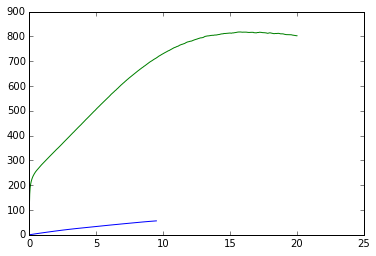

In [39]:
%pylab inline
plt.plot(kyas, kms)
#plt.plot(kyas, ah)
plt.plot(uw_paper[:,0], uw_paper[:,1])